In [1]:
# Import required libraries
import os
import json
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, asdict
import ollama
from openai import OpenAI
import google.generativeai as genai
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


/Users/srinivasarithikghantasala/Documents/Masters/Fall_2025/Data Engineering/NutriGen/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Configure API Keys
# Replace with your actual API keys or set as environment variables

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', '')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY', '') # Replace with your key

# Set up API clients
openai_client = OpenAI(api_key=OPENAI_API_KEY)
genai.configure(api_key=GEMINI_API_KEY)

print("✓ API clients configured")

# Check Ollama
try:
    models = ollama.list()
    print("✓ Ollama is running")
    if any('llama3.1:8b' in m['name'] for m in models['models']):
        print("✓ Llama 3.1:8b is available")
    else:
        print("⚠️  Llama 3.1:8b not found. Pull it with: ollama pull llama3.1:8b")
except:
    print("⚠️  Ollama not running. Start with: ollama serve")

✓ API clients configured
✓ Ollama is running
⚠️  Ollama not running. Start with: ollama serve


In [3]:
# USDA-inspired nutritional database
FOOD_DATABASE = {
    "Barbequeue Lays": (150, 2, 2, 10, "1 oz bag"),
    "Garden Pizza": (285, 12, 4, 10, "1 slice"),
    "Milano double chocolate": (130, 1, 10, 7, "2 cookies"),
    "baked cheddar ruffles": (140, 2, 1, 7, "1 oz"),
    "beef angus burger patty": (290, 19, 0, 23, "4 oz patty"),
    "chocolate milkshake": (530, 12, 72, 15, "16 fl oz"),
    "eggs benedict": (428, 19, 2, 31, "1 serving"),
    "tortilla chips": (140, 2, 0, 7, "1 oz"),
    "grilled chicken breast": (165, 31, 0, 3.6, "3 oz"),
    "Caesar salad": (184, 4, 2, 17, "1.5 cups"),
    "pasta carbonara": (450, 18, 3, 22, "1 cup"),
    "fish tacos": (245, 20, 3, 12, "2 tacos"),
    "vegetable stir-fry": (165, 5, 6, 8, "1 cup"),
    "quinoa bowl": (222, 8, 2, 3.5, "1 cup"),
    "protein shake": (200, 30, 8, 3, "1 shake"),
    "Greek yogurt": (100, 17, 6, 0, "6 oz"),
    "granola bar": (120, 2, 7, 3, "1 bar"),
    "turkey sandwich": (350, 24, 5, 12, "1 sandwich"),
    "fruit smoothie": (250, 3, 42, 1, "16 oz"),
    "rice and beans": (218, 5, 2, 3, "1 cup"),
}

@dataclass
class NutritionProfile:
    """Data class for nutrition profiles with serving notation"""
    foods: Dict[str, float]
    calories: float
    protein: float
    sugar: float

    def to_string(self):
        food_list = "\n".join([f"Food {name} = {quantity}" for name, quantity in self.foods.items()])
        return f"{food_list}\ncalories = {self.calories}\nprotein = {self.protein}\nsugar = {self.sugar}"

    def calculate_totals(self):
        total_cal = 0
        total_prot = 0
        total_sugar = 0

        for food_name, servings in self.foods.items():
            if food_name in FOOD_DATABASE:
                cal, prot, sugar, _, _ = FOOD_DATABASE[food_name]
                total_cal += cal * servings
                total_prot += prot * servings
                total_sugar += sugar * servings

        self.calories = round(total_cal, 2)
        self.protein = round(total_prot, 1)
        self.sugar = round(total_sugar, 1)
        return self.calories, self.protein, self.sugar

print(f"✓ Food database loaded with {len(FOOD_DATABASE)} items")

✓ Food database loaded with 20 items


In [4]:
def generate_prompt(nutrition_profile: NutritionProfile, target_calories: float,
                   target_protein: float, target_sugar: float) -> str:
    """Generate the structured prompt for meal plan generation"""

    food_details = []
    for food_name, servings in nutrition_profile.foods.items():
        if food_name in FOOD_DATABASE:
            _, _, _, _, serving_desc = FOOD_DATABASE[food_name]
            food_details.append(f"Food {food_name} = {servings} (serving size: {serving_desc})")

    food_list = "\n".join(food_details)

    prompt = f"""You are a professional nutritionist creating personalized meal plans.

User's current consumption pattern and available foods with serving quantities:
{food_list}

Current nutritional intake:
calories = {nutrition_profile.calories}
protein = {nutrition_profile.protein}
sugar = {nutrition_profile.sugar}

User's goal is to create a meal plan with:
- Total calories: {target_calories} kcal.
- Total protein: {target_protein} g.
- Total sugar: {target_sugar} g.

The plan must include:
- Breakfast, lunch, dinner, and snacks.
- The calorie count for each meal.
- At the end of each meal plan, provide total calories, total fat, total protein, and total carbohydrate.
- Use serving notation (e.g., "0.5 serving of pasta carbonara").

Provide exactly 3 different meal plan options.

Format each meal plan as:
Meal Plan 1:
- Breakfast: [items] (XXX kcal)
- Lunch: [items] (XXX kcal)
- Dinner: [items] (XXX kcal)
- Snacks: [items] (XXX kcal)
Total Calories: XXXX kcal
Total Protein: XX g
Total Fat: XX g
Total Carbohydrates: XX g"""

    return prompt

def extract_calories_from_response(response: str) -> List[float]:
    """Extract FINAL total calorie values from meal plan response"""
    import re

    calories = []
    sections = re.split(r'\*\*Meal Plan \d+\*\*|Meal Plan \d+:|MEAL PLAN \d+', response, flags=re.IGNORECASE)

    if len(sections) > 1:
        for section in sections[1:4]:
            all_calories = re.findall(r'(\d+(?:\.\d+)?)\s*kcal', section, re.IGNORECASE)
            if all_calories:
                cal_values = [float(c) for c in all_calories]
                meal_plan_totals = [c for c in cal_values if 1000 <= c <= 4000]
                if meal_plan_totals:
                    calories.append(max(meal_plan_totals))
                else:
                    calories.append(0.0)
    else:
        pattern = r'Total Calories?:?\s*(\d+(?:\.\d+)?)\s*kcal'
        matches = re.findall(pattern, response, re.IGNORECASE)
        if matches:
            calories = [float(m) for m in matches if 1000 <= float(m) <= 4000]

    while len(calories) < 3:
        calories.append(0.0)

    return calories[:3]

print("✓ Functions defined")

✓ Functions defined


In [5]:
def generate_test_profiles(num_profiles: int = 5) -> List[Tuple[NutritionProfile, float, float, float]]:
    """Generate test nutrition profiles with serving notation"""

    random.seed(42)  # For reproducibility
    profiles = []
    available_foods = list(FOOD_DATABASE.keys())

    for i in range(num_profiles):
        # Randomly select 6-8 foods
        num_foods = random.randint(6, 8)
        selected_foods = random.sample(available_foods, num_foods)

        # Create food dictionary with serving quantities
        foods = {}
        for food in selected_foods:
            serving_options = [0.5, 1.0, 1.0, 1.0, 1.5, 2.0]
            foods[food] = random.choice(serving_options)

        # Create nutrition profile
        profile = NutritionProfile(foods=foods, calories=0, protein=0, sugar=0)
        profile.calculate_totals()

        # Generate random targets
        target_calories = random.randint(1800, 2800)
        target_protein = random.randint(60, 120)
        target_sugar = random.randint(40, 80)

        profiles.append((profile, target_calories, target_protein, target_sugar))

        print(f"Profile {i+1}:")
        print(f"  Foods: {len(foods)} items")
        print(f"  Current: {profile.calories:.0f} kcal")
        print(f"  Target: {target_calories} kcal")

    return profiles

# Generate 5 test profiles
test_profiles = generate_test_profiles(5)
print(f"\n✓ Generated {len(test_profiles)} test profiles")

Profile 1:
  Foods: 8 items
  Current: 1472 kcal
  Target: 1895 kcal
Profile 2:
  Foods: 8 items
  Current: 2185 kcal
  Target: 2020 kcal
Profile 3:
  Foods: 6 items
  Current: 1010 kcal
  Target: 2796 kcal
Profile 4:
  Foods: 6 items
  Current: 1548 kcal
  Target: 2189 kcal
Profile 5:
  Foods: 8 items
  Current: 4165 kcal
  Target: 2050 kcal

✓ Generated 5 test profiles


In [6]:
def call_llama(prompt: str) -> Tuple[str, float]:
    """Call Llama model via Ollama"""
    try:
        start = time.time()
        response = ollama.chat(
            model='llama3.1:8b',
            messages=[{'role': 'user', 'content': prompt}]
        )
        return response['message']['content'], time.time() - start
    except Exception as e:
        print(f"Llama error: {e}")
        return None, 0

def call_gpt(model_name: str, prompt: str) -> Tuple[str, float]:
    """Call GPT model"""
    try:
        start = time.time()
        response = openai_client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=3000,
            temperature=0.7
        )
        return response.choices[0].message.content, time.time() - start
    except Exception as e:
        print(f"GPT error: {e}")
        return None, 0

def call_gemini(model_name: str, prompt: str) -> Tuple[str, float]:
    """Call Gemini model"""
    try:
        start = time.time()
        model = genai.GenerativeModel(model_name)
        response = model.generate_content(prompt)
        return response.text, time.time() - start
    except Exception as e:
        print(f"Gemini error: {e}")
        return None, 0

print("✓ Model calling functions defined")

✓ Model calling functions defined


In [7]:
# Define models to test
MODELS = [
    ("llama3.1:8b", "ollama"),
    ("gpt-3.5-turbo", "openai"),
    ("gpt-4", "openai"),
    ("gemini-2.5-pro", "gemini"),
    ("gemini-2.0-flash-exp", "gemini")
]

# Results storage
all_results = []

print("Starting evaluation of 5 models on 5 profiles...")
print("="*60)

for model_name, model_type in MODELS:
    print(f"\n📊 Evaluating: {model_name}")
    print("-"*40)

    model_results = []
    total_time = 0

    for idx, (profile, target_cal, target_prot, target_sugar) in enumerate(test_profiles):
        print(f"  Profile {idx+1}/5: ", end="")

        # Generate prompt
        prompt = generate_prompt(profile, target_cal, target_prot, target_sugar)

        # Call appropriate model
        if model_type == "ollama":
            response, proc_time = call_llama(prompt)
        elif model_type == "openai":
            response, proc_time = call_gpt(model_name, prompt)
        elif model_type == "gemini":
            response, proc_time = call_gemini(model_name, prompt)
        else:
            response, proc_time = None, 0

        if response:
            # Extract calories
            actual_calories = extract_calories_from_response(response)
            valid_cals = [c for c in actual_calories if c > 0]

            if valid_cals:
                avg_cal = np.mean(valid_cals)
                error = abs(avg_cal - target_cal)
                error_pct = (error / target_cal) * 100
            else:
                avg_cal = 0
                error = target_cal
                error_pct = 100

            result = {
                'Model': model_name,
                'Profile': idx + 1,
                'Target_Calories': target_cal,
                'Actual_Calories': avg_cal,
                'Error_kcal': error,
                'Error_Percent': error_pct,
                'Processing_Time': proc_time,
                'Success': True,
                'Meal_Plan_1': actual_calories[0],
                'Meal_Plan_2': actual_calories[1],
                'Meal_Plan_3': actual_calories[2]
            }

            print(f"✓ {proc_time:.1f}s, Error: {error_pct:.1f}%")
        else:
            result = {
                'Model': model_name,
                'Profile': idx + 1,
                'Target_Calories': target_cal,
                'Actual_Calories': 0,
                'Error_kcal': target_cal,
                'Error_Percent': 100,
                'Processing_Time': proc_time,
                'Success': False,
                'Meal_Plan_1': 0,
                'Meal_Plan_2': 0,
                'Meal_Plan_3': 0
            }
            print(f"✗ Failed")

        model_results.append(result)
        total_time += proc_time

    all_results.extend(model_results)

    # Calculate model summary
    successful = [r for r in model_results if r['Success']]
    if successful:
        mae = np.mean([r['Error_kcal'] for r in successful])
        mae_pct = np.mean([r['Error_Percent'] for r in successful])
        print(f"\n  Summary: MAE = {mae:.0f} kcal ({mae_pct:.1f}%), Total time = {total_time:.1f}s")
    else:
        print(f"\n  Summary: All failed")

print("\n" + "="*60)
print("✓ Evaluation complete!")

Starting evaluation of 5 models on 5 profiles...

📊 Evaluating: llama3.1:8b
----------------------------------------
  Profile 1/5: ✓ 136.1s, Error: 0.3%
  Profile 2/5: ✓ 88.1s, Error: 11.1%
  Profile 3/5: ✓ 98.2s, Error: 0.4%
  Profile 4/5: ✓ 54.0s, Error: 21.3%
  Profile 5/5: ✓ 156.9s, Error: 3.3%

  Summary: MAE = 155 kcal (7.3%), Total time = 533.3s

📊 Evaluating: gpt-3.5-turbo
----------------------------------------
  Profile 1/5: ✓ 5.7s, Error: 100.0%
  Profile 2/5: ✓ 3.3s, Error: 46.8%
  Profile 3/5: ✓ 5.7s, Error: 100.0%
  Profile 4/5: ✓ 3.7s, Error: 51.6%
  Profile 5/5: ✓ 10.3s, Error: 0.0%

  Summary: MAE = 1353 kcal (59.7%), Total time = 28.7s

📊 Evaluating: gpt-4
----------------------------------------
  Profile 1/5: ✓ 15.5s, Error: 39.2%
  Profile 2/5: ✓ 11.8s, Error: 15.9%
  Profile 3/5: ✓ 1.2s, Error: 100.0%
  Profile 4/5: ✓ 8.6s, Error: 0.0%
  Profile 5/5: ✓ 16.6s, Error: 0.0%

  Summary: MAE = 772 kcal (31.0%), Total time = 53.7s

📊 Evaluating: gemini-2.5-pro
-------

In [9]:
# Convert to DataFrame
df_results = pd.DataFrame(all_results)

# Mark 100% error cases as failures
df_results.loc[df_results['Error_Percent'] >= 100, 'Success'] = False

# Display full results
print("COMPLETE RESULTS TABLE")
print("="*80)
display(df_results)

# Calculate summary statistics per model
print("\n" + "="*80)
print("SUMMARY STATISTICS BY MODEL (Paper's Table II Format)")
print("="*80)

summary_stats = []
for model_name, _ in MODELS:
    model_data = df_results[df_results['Model'] == model_name]
    successful = model_data[(model_data['Success'] == True) & (model_data['Error_Percent'] < 100)]

    if len(successful) > 0:
        stats = {
            'Model': model_name,
            'Success_Rate': f"{len(successful)}/5",
            'MAE_kcal': successful['Error_kcal'].mean(),
            'MAE_Percent': successful['Error_Percent'].mean(),
            'Min_Error_kcal': successful['Error_kcal'].min(),
            'Max_Error_kcal': successful['Error_kcal'].max(),
            'Avg_Time_s': successful['Processing_Time'].mean(),
            'Total_Time_s': model_data['Processing_Time'].sum()  # Total time includes failures
        }
    else:
        stats = {
            'Model': model_name,
            'Success_Rate': "0/5",
            'MAE_kcal': 'N/A',
            'MAE_Percent': 'N/A',
            'Min_Error_kcal': 'N/A',
            'Max_Error_kcal': 'N/A',
            'Avg_Time_s': 'N/A',
            'Total_Time_s': model_data['Processing_Time'].sum()
        }
    summary_stats.append(stats)

df_summary = pd.DataFrame(summary_stats)

# Convert numeric columns where possible
numeric_columns = ['MAE_kcal', 'MAE_Percent', 'Min_Error_kcal', 'Max_Error_kcal', 'Avg_Time_s']
for col in numeric_columns:
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')

# Round numeric values
df_summary = df_summary.round(2)
display(df_summary)

# Print best performing models (excluding N/A values)
print("\n" + "="*80)
print("BEST PERFORMING MODELS (Ranked by MAE %)")
print("="*80)

# Filter out models with N/A (failed models)
df_ranked = df_summary[df_summary['MAE_Percent'].notna()].sort_values('MAE_Percent')

if len(df_ranked) > 0:
    for idx, row in df_ranked.head(3).iterrows():
        print(f"{row['Model']}: {row['MAE_Percent']:.2f}% error ({row['MAE_kcal']:.0f} kcal)")
else:
    print("No models succeeded in generating valid meal plans")

print("\nPaper's reported MAE for Llama 3.1 8B: 1.55%")
print("Paper's reported MAE for GPT-3.5-turbo: 3.68%")

# Show failure analysis
print("\n" + "="*80)
print("FAILURE ANALYSIS")
print("="*80)

for model_name, _ in MODELS:
    model_data = df_results[df_results['Model'] == model_name]
    failures = model_data[(model_data['Success'] == False) | (model_data['Error_Percent'] >= 100)]

    if len(failures) > 0:
        print(f"\n{model_name}:")
        print(f"  Failed profiles: {len(failures)}/5")
        if len(failures) < 5:
            failed_profiles = failures['Profile'].tolist()
            print(f"  Failed on profiles: {failed_profiles}")

COMPLETE RESULTS TABLE


,Model,Profile,Target_Calories,Actual_Calories,Error_kcal,Error_Percent,Processing_Time,Success,Meal_Plan_1,Meal_Plan_2,Meal_Plan_3
0,llama3.1:8b,1,1895,1900.000000,5.000000,0.263852,136.076121,True,1900.0,1900.0,1900.0
1,llama3.1:8b,2,2020,1796.000000,224.000000,11.089109,88.139078,True,1790.0,1620.0,1978.0
2,llama3.1:8b,3,2796,2806.666667,10.666667,0.381497,98.155368,True,1175.0,3707.5,3537.5
3,llama3.1:8b,4,2189,1721.666667,467.333333,21.349170,53.985801,True,1370.0,1865.0,1930.0
4,llama3.1:8b,5,2050,1983.333333,66.666667,3.252033,156.934439,True,1950.0,2000.0,2000.0
5,gpt-3.5-turbo,1,1895,0.000000,1895.000000,100.000000,5.742547,False,0.0,0.0,0.0
6,gpt-3.5-turbo,2,2020,1074.000000,946.000000,46.831683,3.274036,True,1074.0,0.0,0.0
7,gpt-3.5-turbo,3,2796,0.000000,2796.000000,100.000000,5.654259,False,0.0,0.0,0.0
8,gpt-3.5-turbo,4,2189,1060.000000,1129.000000,51.576062,3.690497,True,0.0,0.0,1060.0
9,gpt-3.5-turbo,5,2050,2050.000000,0.000000,0.000000,10.318475,True,2050.0,2050.0,2050.0



SUMMARY STATISTICS BY MODEL (Paper's Table II Format)


,Model,Success_Rate,MAE_kcal,MAE_Percent,Min_Error_kcal,Max_Error_kcal,Avg_Time_s,Total_Time_s
0,llama3.1:8b,5/5,154.73,7.27,5.00,467.33,106.66,533.29
1,gpt-3.5-turbo,3/5,691.67,32.80,0.00,1129.00,5.76,28.68
2,gpt-4,4/5,266.25,13.79,0.00,743.33,13.12,53.71
3,gemini-2.5-pro,5/5,12.80,0.63,0.67,51.67,74.76,373.80
4,gemini-2.0-flash-exp,5/5,124.20,5.83,0.00,348.33,6.11,30.56



BEST PERFORMING MODELS (Ranked by MAE %)
gemini-2.5-pro: 0.63% error (13 kcal)
gemini-2.0-flash-exp: 5.83% error (124 kcal)
llama3.1:8b: 7.27% error (155 kcal)

Paper's reported MAE for Llama 3.1 8B: 1.55%
Paper's reported MAE for GPT-3.5-turbo: 3.68%

FAILURE ANALYSIS

gpt-3.5-turbo:
  Failed profiles: 2/5
  Failed on profiles: [1, 3]

gpt-4:
  Failed profiles: 1/5
  Failed on profiles: [3]


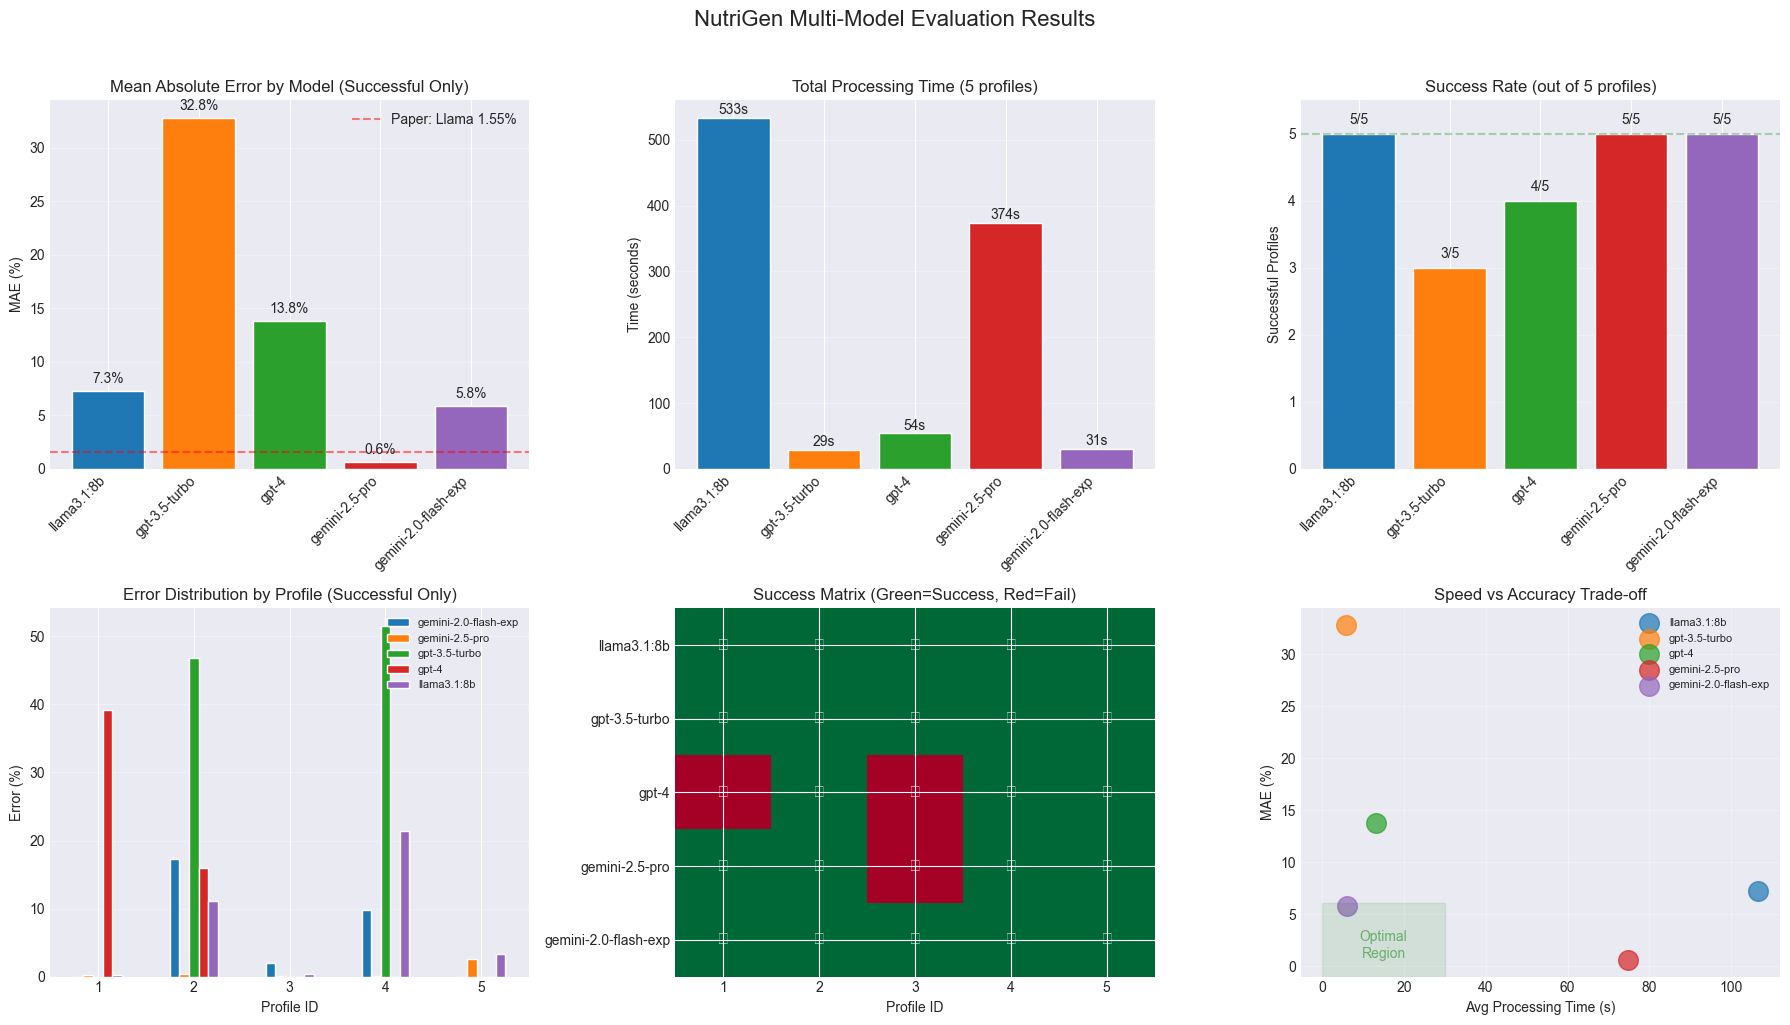


✓ Visualizations created


In [10]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Prepare data - filter out models with N/A values for certain plots
valid_models = df_summary[df_summary['MAE_Percent'].notna()]

# 1. MAE Comparison by Model (only successful models)
ax1 = axes[0, 0]
if len(valid_models) > 0:
    models_list = valid_models['Model'].tolist()
    mae_values = valid_models['MAE_Percent'].tolist()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(models_list)]
    bars = ax1.bar(range(len(models_list)), mae_values, color=colors)
    ax1.set_xticks(range(len(models_list)))
    ax1.set_xticklabels(models_list, rotation=45, ha='right')
    ax1.set_ylabel('MAE (%)')
    ax1.set_title('Mean Absolute Error by Model (Successful Only)')
    ax1.axhline(y=1.55, color='red', linestyle='--', alpha=0.5, label='Paper: Llama 1.55%')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars, mae_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', va='bottom')
else:
    ax1.text(0.5, 0.5, 'No successful models', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Mean Absolute Error by Model')

# 2. Processing Time Comparison (all models)
ax2 = axes[0, 1]
all_models = df_summary['Model'].tolist()
time_values = df_summary['Total_Time_s'].tolist()
colors_all = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars2 = ax2.bar(range(len(all_models)), time_values, color=colors_all)
ax2.set_xticks(range(len(all_models)))
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Total Processing Time (5 profiles)')
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars2, time_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.0f}s', ha='center', va='bottom')

# 3. Success Rate by Model
ax3 = axes[0, 2]
success_rates = []
for model in all_models:
    success_str = df_summary[df_summary['Model'] == model]['Success_Rate'].iloc[0]
    success_count = int(success_str.split('/')[0])
    success_rates.append(success_count)

bars3 = ax3.bar(range(len(all_models)), success_rates, color=colors_all)
ax3.set_xticks(range(len(all_models)))
ax3.set_xticklabels(all_models, rotation=45, ha='right')
ax3.set_ylabel('Successful Profiles')
ax3.set_ylim(0, 5.5)
ax3.set_title('Success Rate (out of 5 profiles)')
ax3.axhline(y=5, color='green', linestyle='--', alpha=0.3, label='Perfect Score')
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars3, success_rates):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val}/5', ha='center', va='bottom')

# 4. Error Distribution by Profile
ax4 = axes[1, 0]
successful_only = df_results[df_results['Success'] == True]
if len(successful_only) > 0:
    profile_errors = successful_only.pivot_table(index='Profile', columns='Model',
                                                  values='Error_Percent', aggfunc='mean')
    profile_errors.plot(kind='bar', ax=ax4, color=colors_all[:len(profile_errors.columns)])
    ax4.set_xlabel('Profile ID')
    ax4.set_ylabel('Error (%)')
    ax4.set_title('Error Distribution by Profile (Successful Only)')
    ax4.legend(fontsize=8, loc='upper right')
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
else:
    ax4.text(0.5, 0.5, 'No successful results', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Error Distribution by Profile')

# 5. Success/Failure Heatmap
ax5 = axes[1, 1]
success_matrix = df_results.pivot_table(index='Profile', columns='Model',
                                         values='Success', aggfunc='first')
success_matrix = success_matrix.astype(float)
im = ax5.imshow(success_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax5.set_xticks(range(5))
ax5.set_xticklabels(range(1, 6))
ax5.set_yticks(range(len(all_models)))
ax5.set_yticklabels(all_models)
ax5.set_xlabel('Profile ID')
ax5.set_title('Success Matrix (Green=Success, Red=Fail)')

# Add text annotations
for i in range(len(all_models)):
    for j in range(5):
        if not pd.isna(success_matrix.iloc[j, i]):
            text = ax5.text(j, i, '✓' if success_matrix.iloc[j, i] else '✗',
                           ha="center", va="center", color="white", fontweight='bold', fontsize=12)

# 6. Scatter: Processing Time vs Accuracy (only successful models)
ax6 = axes[1, 2]
if len(valid_models) > 0:
    for idx, row in valid_models.iterrows():
        model_name = row['Model']
        color_idx = all_models.index(model_name)
        ax6.scatter(row['Avg_Time_s'], row['MAE_Percent'],
                   s=200, color=colors_all[color_idx], alpha=0.7, label=model_name)

    ax6.set_xlabel('Avg Processing Time (s)')
    ax6.set_ylabel('MAE (%)')
    ax6.set_title('Speed vs Accuracy Trade-off')
    ax6.legend(fontsize=8)
    ax6.grid(True, alpha=0.3)

    # Add optimal region
    ax6.axvspan(0, 30, ymin=0, ymax=0.2, alpha=0.1, color='green')
    ax6.text(15, 2, 'Optimal\nRegion', ha='center', va='center', color='green', alpha=0.5)
else:
    ax6.text(0.5, 0.5, 'No successful models to plot', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Speed vs Accuracy Trade-off')

plt.suptitle('NutriGen Multi-Model Evaluation Results', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations created")

In [13]:
# Save detailed results
df_results.to_csv('nutrigen_multimodel_results.csv', index=False)
print("✓ Saved: nutrigen_multimodel_results.csv")

# Save summary statistics
df_summary.to_csv('nutrigen_multimodel_summary.csv', index=False)
print("✓ Saved: nutrigen_multimodel_summary.csv")

# Save test profiles
profile_data = []
for idx, (profile, target_cal, target_prot, target_sugar) in enumerate(test_profiles):
    profile_data.append({
        'profile_id': idx + 1,
        'foods_with_servings': json.dumps(profile.foods),
        'current_calories': profile.calories,
        'current_protein': profile.protein,
        'current_sugar': profile.sugar,
        'target_calories': target_cal,
        'target_protein': target_prot,
        'target_sugar': target_sugar
    })

df_profiles = pd.DataFrame(profile_data)
df_profiles.to_csv('nutrigen_test_profiles.csv', index=False)
print("✓ Saved: nutrigen_test_profiles.csv")

# Create comparison table (Paper vs Our Results)
comparison_data = []
for model in ['llama3.1:8b', 'gpt-3.5-turbo', 'gpt-4']:
    model_stats = df_summary[df_summary['Model'] == model]
    if not model_stats.empty:
        comparison_data.append({
            'Model': model,
            'Our_MAE_Percent': model_stats['MAE_Percent'].iloc[0],
            'Paper_MAE_Percent': 1.55 if 'llama' in model.lower() else 3.68 if '3.5' in model else 'N/A'
        })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("COMPARISON WITH PAPER RESULTS")
print("="*60)
display(df_comparison)

✓ Saved: nutrigen_multimodel_results.csv
✓ Saved: nutrigen_multimodel_summary.csv
✓ Saved: nutrigen_test_profiles.csv

COMPARISON WITH PAPER RESULTS


,Model,Our_MAE_Percent,Paper_MAE_Percent
0,llama3.1:8b,7.27,1.55
1,gpt-3.5-turbo,32.80,3.68
2,gpt-4,13.79,N/A


In [14]:
# Find and display the best performing result
best_result = df_results[df_results['Success'] == True].nsmallest(1, 'Error_Percent')

if not best_result.empty:
    best = best_result.iloc[0]
    print("="*80)
    print(f"BEST PERFORMING RESULT")
    print("="*80)
    print(f"Model: {best['Model']}")
    print(f"Profile: {best['Profile']}")
    print(f"Target Calories: {best['Target_Calories']} kcal")
    print(f"Generated Calories: {best['Actual_Calories']:.0f} kcal")
    print(f"Error: {best['Error_kcal']:.0f} kcal ({best['Error_Percent']:.1f}%)")
    print(f"Processing Time: {best['Processing_Time']:.1f} seconds")
    print(f"\nMeal Plan Calories:")
    print(f"  Plan 1: {best['Meal_Plan_1']:.0f} kcal")
    print(f"  Plan 2: {best['Meal_Plan_2']:.0f} kcal")
    print(f"  Plan 3: {best['Meal_Plan_3']:.0f} kcal")

BEST PERFORMING RESULT
Model: gpt-3.5-turbo
Profile: 5
Target Calories: 2050 kcal
Generated Calories: 2050 kcal
Error: 0 kcal (0.0%)
Processing Time: 10.3 seconds

Meal Plan Calories:
  Plan 1: 2050 kcal
  Plan 2: 2050 kcal
  Plan 3: 2050 kcal


In [11]:
print("="*80)
print("NUTRIGEN MULTI-MODEL EVALUATION FINAL REPORT")
print("="*80)

print("\n📊 EVALUATION SCOPE:")
print(f"  • Models Tested: {len(MODELS)}")
print(f"  • Test Profiles: {len(test_profiles)}")
print(f"  • Total Evaluations: {len(MODELS) * len(test_profiles)}")

print("\n🏆 MODEL RANKINGS (by MAE %):")
for i, row in df_summary.sort_values('MAE_Percent').iterrows():
    print(f"  {i+1}. {row['Model']}: {row['MAE_Percent']:.2f}% ({row['MAE_kcal']:.0f} kcal)")

print("\n⚡ FASTEST MODELS (avg time per profile):")
for i, row in df_summary.sort_values('Avg_Time_s').head(3).iterrows():
    print(f"  {i+1}. {row['Model']}: {row['Avg_Time_s']:.1f} seconds")

print("\n📈 KEY FINDINGS:")
best_model = df_summary.sort_values('MAE_Percent').iloc[0]
print(f"  • Best Accuracy: {best_model['Model']} with {best_model['MAE_Percent']:.2f}% error")
fastest_model = df_summary.sort_values('Avg_Time_s').iloc[0]
print(f"  • Fastest Model: {fastest_model['Model']} at {fastest_model['Avg_Time_s']:.1f}s per profile")

# Calculate overall statistics
overall_success_rate = (df_results['Success'].sum() / len(df_results)) * 100
overall_mae = df_results[df_results['Success'] == True]['Error_Percent'].mean()
print(f"  • Overall Success Rate: {overall_success_rate:.1f}%")
print(f"  • Overall MAE: {overall_mae:.2f}%")

print("\n📚 COMPARISON WITH PAPER:")
print("  • Paper reported Llama 3.1 8B: 1.55% MAE")
our_llama = df_summary[df_summary['Model'] == 'llama3.1:8b']
if not our_llama.empty:
    print(f"  • Our Llama 3.1 8B: {our_llama['MAE_Percent'].iloc[0]:.2f}% MAE")
print("  • Paper reported GPT-3.5-turbo: 3.68% MAE")
our_gpt35 = df_summary[df_summary['Model'] == 'gpt-3.5-turbo']
if not our_gpt35.empty:
    print(f"  • Our GPT-3.5-turbo: {our_gpt35['MAE_Percent'].iloc[0]:.2f}% MAE")

print("\n" + "="*80)
print("✅ Evaluation Complete - Results saved to CSV files")
print("="*80)

NUTRIGEN MULTI-MODEL EVALUATION FINAL REPORT

📊 EVALUATION SCOPE:
  • Models Tested: 5
  • Test Profiles: 5
  • Total Evaluations: 25

🏆 MODEL RANKINGS (by MAE %):
  4. gemini-2.5-pro: 0.63% (13 kcal)
  5. gemini-2.0-flash-exp: 5.83% (124 kcal)
  1. llama3.1:8b: 7.27% (155 kcal)
  3. gpt-4: 13.79% (266 kcal)
  2. gpt-3.5-turbo: 32.80% (692 kcal)

⚡ FASTEST MODELS (avg time per profile):
  2. gpt-3.5-turbo: 5.8 seconds
  5. gemini-2.0-flash-exp: 6.1 seconds
  3. gpt-4: 13.1 seconds

📈 KEY FINDINGS:
  • Best Accuracy: gemini-2.5-pro with 0.63% error
  • Fastest Model: gpt-3.5-turbo at 5.8s per profile
  • Overall Success Rate: 88.0%
  • Overall MAE: 10.10%

📚 COMPARISON WITH PAPER:
  • Paper reported Llama 3.1 8B: 1.55% MAE
  • Our Llama 3.1 8B: 7.27% MAE
  • Paper reported GPT-3.5-turbo: 3.68% MAE
  • Our GPT-3.5-turbo: 32.80% MAE

✅ Evaluation Complete - Results saved to CSV files
